In [238]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from warnings import filterwarnings
from chainer import serializers
#print(check_output(["dir", "C:/Users/User/Documents/RL_"]).decode("utf8"))
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)  
# Any results you write to the current directory are saved as output.

In [239]:
import time
import copy
import numpy as np
import array as arr
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from plotly.offline import plot
import datetime
import plotly.graph_objects as go
#from plotly import tools
#from plotly.graph_objs import *
#from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [240]:
data = pd.read_csv('C:/Users/User/Documents/RL_/Data/Stocks/SPY_Both.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2001-01-02 00:00:00 2019-12-30 00:00:00


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj Close,WTI_Adj Close
Date,,,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000,268.399994,27.200001
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000,268.000000,27.950001
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000,267.299988,28.200001
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000,268.000000,28.000000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000,268.000000,27.350000


In [241]:
start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime(2019, 12, 31)
total_days = (end_date - start_date).days
train_days = int(total_days * 0.5)
test_start_date = start_date + datetime.timedelta(days=train_days)
date_split = test_start_date.date()
train = data[:date_split]
test = data[date_split:]
print("訓練", start_date.date(), "到", test_start_date.date())
print("測試", test_start_date.date(), "到", end_date.date())

訓練 2001-01-01 到 2010-07-02
測試 2010-07-02 到 2019-12-31


In [242]:
def plot_train_test(train, test, date_split):
    # 创建图形
    train_candle = go.Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='Train')
    test_candle = go.Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='Test')
    
    fig = go.Figure(data=[train_candle, test_candle])
    
    # 添加分割线
    fig.add_shape(
        type="line",
        x0=date_split, y0=min(min(train['Low']), min(test['Low'])),
        x1=date_split, y1=max(max(train['High']), max(test['High'])),
        line=dict(color="Black", width=2)
    )
    
    # 添加注释
    fig.add_annotation(
        x=date_split, y=max(max(train['High']), max(test['High'])), ax=0, ay=-30,
        xref='x', yref='y',
        showarrow=True, arrowhead=1,
        text="Start of Test Data"
    )
    
    # 更新布局
    fig.update_layout(title='Train and Test Data Visualization', xaxis_title='Date', yaxis_title='Price')
    
    # 显示图形
    plot(fig)

# 调用函数
plot_train_test(train, test, date_split)

In [243]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 10000 #初始資金
        self.count = []
        self.positions = []
        self.position_value = 0
        self.brok_rate=0.0009
        self.max_trade_percent = 0.8
        self.tbrokerage = 0
        self.history = [0 for _ in range(self.history_t)]
        self.Act0=0
        self.Act1=0
        self.Act2=0
        self.RW_p=0
        self.RW_n=0
        self.RW_p_v=0
        self.RW_n_v=0
        return [self.position_value] + self.history # obs
    
    def step(self, act, amount):
        
        if self.t >= len(self.data) - 1:
            self.done = True
            return [self.position_value] + self.history, 0, self.done

        reward = 0
        #print(act)
        #print(amount)
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if self.profits != 0:
                max_trade_amount = self.profits*self.max_trade_percent
                stock_price = self.data.iloc[self.t, :]['Close']
                count = max_trade_amount / stock_price
                #self.tbrokerage = self.brok_rate*self.data.iloc[self.t, :]['Close']
                buyin = stock_price * count
                self.profits = self.profits - buyin 
                #print('\t'.join(map(str, ['buy',self.data.iloc[self.t, :]['Close'], amount, buyin, self.profits])))
                self.positions.append(stock_price)
                self.count.append(count)
                self.Act1+=1
                #print('\t'.join(map(str, ['buy', amount, buyin, self.profits])))
                
        elif act == 2: # sell
            if len(self.positions) > 0:
                sell_ratio = self.determine_sell_ratio(amount)
                num_positions_to_sell = int(len(self.positions) * sell_ratio)

                for i in range(num_positions_to_sell):
                    sell_price = self.data.iloc[self.t, :]['Close']
                    buy_price = self.positions[i]
                    count = self.count[i]
                    abs_num = (sell_price - buy_price) * count
                    if abs_num > 0: 
                        self.RW_p += 1 
                        self.RW_p_v += abs_num
                    else: 
                        self.RW_n += 1
                        self.RW_n_v += abs(abs_num)
                    reward += sell_price * count
                    self.profits += sell_price * count
                self.positions = self.positions[num_positions_to_sell:]
                self.count = self.count[num_positions_to_sell:]
                self.Act2 += 1    
        
        else :
            self.Act0+=1
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
    def determine_sell_ratio(self, signal_strength):
        # Example thresholds and ratios
        thresholds = [0.2, 0.5, 0.8]
        ratios = [0.25, 0.5, 0.75]

        for i, threshold in enumerate(thresholds):
            if signal_strength < threshold:
                return ratios[i]
        return ratios[0]  # Sell the largest ratio but not everything if the signal is very strong

In [244]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    amount = 0.333
    print(env.step(pact,amount))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([64.29003899999998, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.29003899999998], 0, False)
([50.06994600000007, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.29003899999998, -14.220092999999906], 0, False)
([15.079956000000038, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [245]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 1
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    start = time.time()

    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
                
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                #pact = np.argmax(softmax_q_values)
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            #log_profits = 0
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('2001_Both_dqn_model.npz', Q)        
    return Q, total_losses, total_rewards
    

In [246]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	10152.1227967571	444	339	1603
1	249	185	14065.079158633003	13912.476673850237
2	10848.737511360374	284	200	1904
2	171	110	12599.167847388971	11224.491495099273
3	11622.521443461252	301	189	1898
3	182	115	12711.703161889473	10006.395344977023
4	7304.855588911174	276	198	1914
4	155	119	9898.261220910335	12304.211460628434
5	10794.147061025997	418	151	1819
5	235	176	14234.953140698091	13398.43834370315
6	7275.118692557162	435	176	1776
6	254	170	10034.634503282914	11845.44074864758
7	5504.58668556626	387	202	1798
7	211	152	7046.088102056545	11267.078213000052
8	6740.484835365723	499	133	1755
8	270	220	8926.679191641753	11835.662293187203
9	7473.246803268678	527	132	1729
9	290	232	10771.207035058145	12925.155153505495
10	6519.429252459366	564	144	1678
10	327	233	7939.20775014182	10997.277378943016
11	7235.585681734796	483	168	1737
11	259	215	9287.358844892493	11554.82137539681
12	8832.51705017919	516	158	1714
12	264	225	9767.803510422698	10146.3335745

102	11887.215557441372	609	94	1685
102	360	227	14283.918841990644	10549.130235224962
103	7696.734378888877	544	75	1769
103	314	218	8570.21969305124	10309.650594982295
104	8826.457984478153	604	85	1699
104	365	220	10574.453727050246	10173.551082574886
105	7140.328121689761	582	91	1715
105	347	228	10022.64470024232	12064.72956607593
106	10559.3864051427	629	101	1658
106	344	273	12060.7245349551	10720.482966794054
107	9036.179178258488	574	103	1711
107	347	220	12088.639896218681	11526.453481345148
108	7869.602403797747	584	75	1728
108	352	221	8953.686085762485	10464.277142626574
109	6875.6585180145885	585	77	1726
109	327	239	9151.339847374316	11303.153801460434
110	8051.787949161728	601	77	1710
110	332	261	8441.144592515111	10058.73011516699
111	7643.375950529375	571	94	1723
111	317	247	11546.448583519239	13356.046888106875
112	7970.943175978706	526	105	1757
112	292	229	11789.880405867534	13660.261705692894
113	7664.190662735618	543	79	1765
113	267	256	10132.251933789641	11529.92022041612

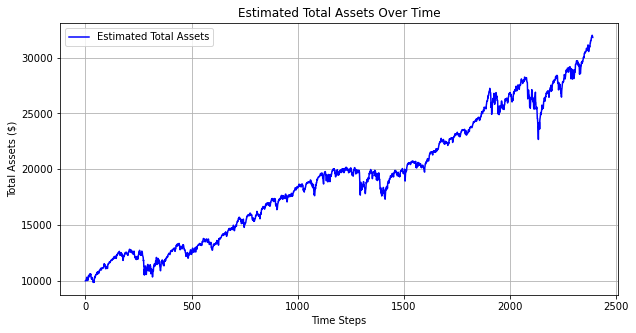

Final profits: 31811.107755020552


In [247]:
import matplotlib.pyplot as plt

def test_dqn(test_env, Q, confidence_threshold_buy=0.1, confidence_threshold_sell=0.8):
    # 重置环境
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    estimated_total_assets = [test_env.profits]  # 记录每步的总资产，初始资金为起始值

    while not test_env.done:
        # 使用DQN产生行动的概率分布
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data
        pact = np.random.choice(3, p=softmax_q_values.ravel())
        
        # 根据设定的阈值判断是否执行买入或卖出
        amount = softmax_q_values.ravel()[pact]
        if pact == 2 and amount < confidence_threshold_sell:
            pact = 0
        elif pact == 1 and amount < confidence_threshold_buy:
            pact = 0
        
        # 执行行动
        obs, reward, done = test_env.step(pact, amount)
        test_acts.append(pact)
        test_rewards.append(reward)
        pobs = obs

        # 估算总资产
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)

    # 绘制估算总资产的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_profits = total_assets
    return test_acts, test_rewards, final_profits
def load_and_test_dqn(test_env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('2001_Both_dqn_model.npz', Q_loaded)
    
    # 现在使用加载的模型来进行测试
    test_acts, test_rewards, test_profits = test_dqn(test_env, Q_loaded)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)
# 调用函数进行测试
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dqn(test_env)

In [248]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)
    

In [249]:
# Double DQN

def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()    
    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    gamma = 0.97
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    save_models(Q, Q_ast)       
    return Q, total_losses, total_rewards
def save_models(Q, Q_ast, behavior_filename='2001_Both_ddqn_behavior_model.npz', target_filename='2001_Both_ddqn_target_model.npz'):
    serializers.save_npz(behavior_filename, Q)
    serializers.save_npz(target_filename, Q_ast)

In [250]:
Q, total_losses, total_rewards = train_ddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	8431.223858945212	562	387	1437
1	291	266	14219.135168035358	15243.195618520362
2	7137.18570184309	459	178	1750
2	285	161	9624.586536223891	12021.549767383543
3	9917.203397852874	540	174	1674
3	297	238	14784.196629779737	14068.292808280012
4	7849.841148674094	604	124	1660
4	342	255	10523.52226805012	12124.328512351522
5	8890.981460324883	709	97	1582
5	325	377	10893.395254962994	11968.62560146222
6	6563.924107445976	670	104	1614
6	356	288	8275.026149330035	10881.654132066322
7	7540.484254020025	689	95	1604
7	407	259	9964.553877646622	11359.346364617992
8	9904.302433029648	676	99	1613
8	404	253	13492.763216140702	11987.465950476784
9	8692.033224322227	540	134	1714
9	297	238	10913.211070884758	11815.65322799726
10	9215.676394115659	587	172	1629
10	319	248	13587.505895684786	13350.696720050151
11	9741.781275704217	666	135	1587
11	387	226	11630.75711300535	11430.496732716492
12	9282.796793012338	700	96	1592
12	380	271	11836.498991680752	12021.264020628

102	9097.605508624596	600	99	1689
102	346	245	14333.532023161853	14846.977107640876
103	8790.96654131379	634	84	1670
103	362	252	12257.403398177676	12042.403713205857
104	9043.287662978242	588	86	1714
104	335	244	8286.59366352337	8632.187018973276
105	9707.679757097048	581	87	1720
105	342	224	10983.117030003288	9769.962977136378
106	7363.155120463712	590	70	1728
106	341	218	7342.127464491753	9476.451407262046
107	7691.340745686702	576	96	1716
107	310	249	9886.071841372845	11504.423749256617
108	8784.440064229566	595	79	1714
108	308	267	10870.518713974325	11497.988939082488
109	8464.714255377867	523	89	1776
109	288	227	10906.270522200866	12238.739088575228
110	10735.420592121285	563	98	1727
110	373	179	12681.62747832188	11307.974837383012
111	8168.769130959878	589	92	1707
111	292	285	10648.38643705217	12350.911250847726
112	8726.696537416115	565	98	1725
112	298	248	9249.44070561867	9266.714872602892
113	7965.371633641903	592	73	1723
113	308	276	9152.53139230587	10614.94583052591
114	104

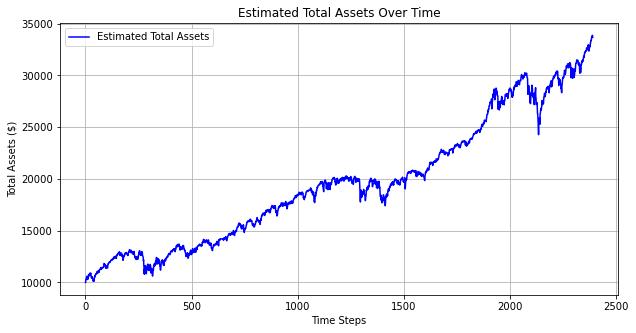

Final profits: 33682.52914580722


In [251]:
import matplotlib.pyplot as plt

def test_ddqn(test_env, Q, Q_ast, buy_threshold=0.1, sell_threshold=0.8):
    # 重置环境并获取初始状态
    pobs = test_env.reset()
    test_env.profits = 10000  # 如果需要的话，重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = [test_env.profits]  # 记录每一步后的利润
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表

    while not test_env.done:
        # 使用训练好的DDQN模型选择行动
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)
        action_prob = softmax_q_values[action]
        amount = action_prob

        # 根据阈值判断是否执行买入或卖出
        if action == 1 and action_prob < buy_threshold:
            action = 0
            amount = 0
        elif action == 2 and action_prob < sell_threshold:
            action = 0
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        if done:
            break
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs
        test_profits.append(test_env.profits)

        # 估算总资产（不实际卖出股票）
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)
    # 测试最后一天，将所有持股转换为现金
    final_stock_value = sum(c * test_env.data.iloc[-1]['Close'] for c in test_env.count)
    final_profits = test_env.profits + final_stock_value
    estimated_total_assets[-1] = final_profits  # 更新最后的总资产估计值
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    

    # 绘制总资产变化的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Final profits:", final_profits)
    return test_acts, test_rewards, final_profits

class Q_Network(chainer.Chain):

    def __init__(self, input_size, hidden_size, output_size):
        super(Q_Network, self).__init__(
            fc1 = L.Linear(input_size, hidden_size),
            fc2 = L.Linear(hidden_size, hidden_size),
            fc3 = L.Linear(hidden_size, output_size)
        )

    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        y = self.fc3(h)
        return y

    def reset(self):
        self.zerograds() 
# 确保以下是您实际调用测试函数的部分
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)

Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('2001_Both_ddqn_behavior_model.npz', Q_loaded)

Q_ast_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('2001_Both_ddqn_target_model.npz', Q_ast_loaded)

# 运行测试
test_acts, test_rewards, test_profits = test_ddqn(test_env, Q_loaded, Q_ast_loaded)

In [252]:
# Dueling Double DQN

def train_dddqn(env):

    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('2001_Both_dueling_ddqn_model.npz', Q)
    chainer.serializers.save_npz('2001_Both_dueling_ddqn_target_model.npz', Q_ast)        
    return Q, total_losses, total_rewards

In [253]:
Q, total_losses, total_rewards = train_dddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	6783.193111560385	563	359	1462
1	309	250	13804.743416050595	15873.781909454885
2	8230.001393806742	633	121	1634
2	391	224	9773.0639226576	10657.896229083728
3	7502.442027362818	713	76	1599
3	440	247	9184.887898049918	10721.163695927242
4	8675.19976630529	698	114	1575
4	377	313	10770.642531728166	11508.6751510441
5	8584.230300884345	703	107	1578
5	387	291	10308.302171760766	11110.05301980453
6	7414.866657449037	710	95	1583
6	407	275	11445.814598923926	12940.51631527597
7	7998.700871427596	734	85	1569
7	416	314	10759.407479656982	12425.789122810065
8	6902.606592054178	752	79	1557
8	400	341	10091.859638765765	12703.48168187345
9	10172.22747022032	774	78	1536
9	447	318	15359.321899565808	14366.36336281462
10	7632.510659611132	697	91	1600
10	394	276	11153.31811990637	12399.011373703584
11	7248.925179272502	771	88	1529
11	399	361	8240.076286780188	10495.917943889908
12	9836.603880192699	717	75	1596
12	399	286	13320.021878856667	11902.156728322616
13	99

102	8840.620710476203	495	97	1796
102	270	219	11293.941248446254	11664.904518274705
103	9502.059403152427	554	91	1742
103	304	244	11130.403977380278	11141.29754064292
104	7404.835569835184	525	76	1787
104	294	208	9767.67992266118	11325.111719071578
105	9740.7261479679	514	82	1792
105	306	202	12105.49354413101	11982.309139014958
106	8524.745623666386	557	88	1743
106	316	231	9799.384973855047	11142.306274588784
107	6586.453949407864	524	79	1785
107	285	232	10151.480739550067	12637.23016050935
108	7220.612005030985	571	67	1750
108	292	246	6220.736403891757	8594.902612805381
109	9382.675461413255	544	76	1768
109	300	230	11215.669429015228	10383.265547776326
110	10019.576425522191	532	81	1775
110	292	231	13306.355812973605	13124.11803901682
111	6653.539045914269	543	75	1770
111	319	218	7722.81515793599	11026.31242765637
112	7781.338623732941	519	68	1801
112	302	198	8562.142237912834	9794.962474198841
113	8924.03642940289	540	80	1768
113	302	232	10893.180445690701	11505.380460206708
114	6621

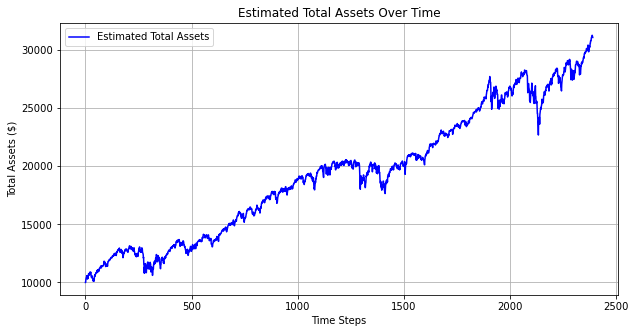

Final profits: 31084.931465354803


In [254]:
import plotly.graph_objects as go
import numpy as np

def test_dueling_ddqn(test_env, Q, buy_threshold=0.1, sell_threshold=0.8):
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = []
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表
    while not test_env.done:
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)  # 随机选择行动，基于概率分布
        action_prob = softmax_q_values[action]

        # 设置交易的金额或数量，这里假设简单地将概率值转换为金额或比例
        amount = action_prob

        # 考虑不同行动的阈值
        if action == 1 and action_prob < buy_threshold:  # 买入行动的阈值判断
            action = 0  # 如果买入概率低于买入阈值，则不买入
            amount = 0
        elif action == 2 and action_prob < sell_threshold:  # 卖出行动的阈值判断
            action = 0  # 如果卖出概率低于卖出阈值，则不卖出
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs

        # 估计每日的现有资金（假设所有持仓都卖出但不真正执行）
        simulated_profits = test_env.profits + sum(pos * test_env.data.iloc[test_env.t, :]['Close'] for pos in test_env.count)
        test_profits.append(simulated_profits)
        estimated_total_assets.append(simulated_profits)
    # 绘制折线图显示每日利润变化
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    test_env.profits = simulated_profits
    return test_acts, test_rewards, test_env.profits

def load_and_test_dueling_ddqn(test_env):
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('2001_Both_dueling_ddqn_model.npz', Q_loaded)
    test_acts, test_rewards, test_profits = test_dueling_ddqn(test_env, Q_loaded, buy_threshold=0.1, sell_threshold=0.6)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)

test_data = test  # 这里应该是您加载或定义测试数据集的代码
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dueling_ddqn(test_env)